# Table of Contents

2. <a href='#scraping'>Web Scraping Go Fund Me</a>


3. <a href='#preprocessing'>Example of Preprocessing</a>


4. <a href='#imports'>Import modules and dataframe</a>


5. <a href='#data cleaning'>Data Cleaning</a>

    5.1. <a href ='#p&s scores'>Create Polarity and Subjectivity Scores</a>
    
    5.2. <a href = '#outliers'>Deal with Outliers </a>
    
    
6. <a href='#analysis'>Data Analysis</a>


7. <a href='#baseline'>Modeling Baseline</a>


8. <a href= '#feature'>Feature Engineering</a>

    6.1. <a href='#more features'>Adding more features</a>
    
    
9. <a href= '#interpret'>Interpret Results</a>


10. <a href= '#residual'>Extra-Residual Plot</a>



# Web Scraping 
<a id='scraping'></a>

In [ ]:
from bs4 import BeautifulSoup
import re
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time
import os
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
import re
import pandas as pd
import numpy as np
import pickle
    
def scrape_website(website):
 
    chromedriver = "/Applications/chromedriver" # path to the chromedriver executable
    os.environ["webdriver.chrome.driver"] = chromedriver
    
    matrix_url = website
    driver = webdriver.Chrome(chromedriver)
    driver.get(matrix_url)
    
    
    n = 0
    while n < 3:
        element = WebDriverWait(driver, 50).until(EC.visibility_of_element_located((By.XPATH, "//a[@data-gfm-analytics-element='btn_showmore_browse']")))
        element.click()
        ##show_more = '//a[@data-gfm-analytics-element="btn_showmore_browse"]'
        ##driver.find_element_by_xpath(show_more).click()
        n += 1

    soup = BeautifulSoup(driver.page_source, 'html.parser')
    list_of_urls = []
    
    for link in soup.findAll('a', attrs={'href': re.compile("https://www.gofundme.com")}):
        url = (link.get('href'))
        list_of_urls.append(url)

    user_agent = 'Mozilla/5.0 (X11; U; Linux i686; en-US) AppleWebKit/534.3 (KHTML, like Gecko) Chrome/6.0.472.63 Safari/534.3'
    headers = {'User-Agent': user_agent}

    list_of_info = []
    list_of_errors = []
    for url in list(set(list_of_urls)):
        element = requests.get(url, headers = headers)
    
        try: 
            soup = BeautifulSoup(element.text, "lxml")
        except:
            print (f"Couldn't load {url}, {element.status_code}")
            continue

        
        try:
            a = soup.find("script").get_text()
        except:
            print ('NA')
        #a
        try:
            campaign_story = soup.find("div", "co-story truncate-text truncate-text--description js-truncate").get_text()
        except:
            try:
                campaign_story = soup.find("div", "o-campaign-story").get_text()
            except:
                campaign_story = 'None'
        #b
        try:
            campaign_day_created = soup.find("div", "created-date").get_text()
        except:
            try:
                campaign_day_created = soup.find("span", "m-campaign-byline-created").get_text()
            except: 
                campaign_day_created = 'None'
        #c
        try:
            campaign_progress = soup.find("div", "layer-white hide-for-large mb10").get_text()
        except:
    
            campaign_progress = soup.find("div", "o-campaign-sidebar-progress-meter m-progress-meter").get_text()
            #except:
             #   list_of_errors.append((url, 'progress'))
        #d
        try:
            location = soup.find("a", "icon-link location-name js-location-link").get_text()
        except:
            try:
                location = str(re.findall(r'\"location":\{.*\}', element.text))
            except:
                list_of_errors.append((url, 'location'))
        #e
        
            #social_share_total = str(re.findall(r'\"social_share_total":\d+', a))
        #f
            campaignShares = str(re.findall(r'\"campaignShares":\d+', a))
            
            
            info_list = [campaign_story, campaign_day_created, campaign_progress, location, campaignShares ]
        
            list_of_info.append(info_list)
        time.sleep(4)  
        
    df = pd.DataFrame(list_of_info, columns=('story', 'date_created', 'progress', 'location', 'campaignShares'))
    
        
    return list_of_urls
        
g = scrape_website('https://www.gofundme.com/discover/other-fundraiser')
#with open('other2_scrape', 'wb') as picklefile:
 #   pickle.dump(scrape_website('https://www.gofundme.com/discover/other-fundraiser'), picklefile)
    



# Example of Preprocessing
<a id='preprocessing'></a>

In [ ]:
import pandas as pd
import datetime as dt
import re
from dateutil.parser import parse
import pickle

def drop_columns(pickle_file):
    df = pd.read_pickle(pickle_file)
    df = df.drop_duplicates()
    df = df.drop(['location'], axis=1)
    return df
    
def date_preprocessing(df):
    
    #clean up date_created
    date_created_edit = [element.replace("Created", "").strip() for element in df['date_created']]
    df['date_created_edit'] = date_created_edit
    
    #edit as needed
    df['date_created_edit_2'] = df['date_created_edit'].replace({'3 days ago': 'July 9, 2019'})
    
    #checking for inconsistencies with dates, edit as needed.
    list_of_days_ago = []
    list_of_dates = []
    for element in df['date_created_edit_2']:
        try:
            dt = parse(element)
            dates = dt.strftime('%m/%d/%Y')
            list_of_dates.append(dates)
        except:
            list_of_days_ago.append(element)

        

    df['date_created_edit_3'] = list_of_dates
    
    df['day_scraped'] = 'July 12, 2019'

    day_scraped_datetime = []
    for element in df['day_scraped']:
        dt = parse(element)
        dates = dt.strftime('%m/%d/%Y')
        day_scraped_datetime.append(dates)

    df['day_scraped_datetime'] = day_scraped_datetime

    df['day_scraped_datetime'] = pd.to_datetime(df['day_scraped_datetime'])

    df['date_created_edit_3'] = pd.to_datetime(df['date_created_edit_3'])

    df['days_active'] = (df['day_scraped_datetime'] - df['date_created_edit_3']).dt.days
    
    return df
    
    #return list_of_days_ago

def add_category(df):
    df['category'] = 'family'
    return df

def progress_processing(df):
    raised_list = []
    goal_list = []
    for element in df['progress']:
        raised = element.split()[0]
        goal = element.split()[3]
        raised_list.append(raised)
        goal_list.append(goal)
    df['money_raised'] = raised_list
    df['goal'] = goal_list
    
    list_of_money = [int(''.join(re.findall(r'\d+', element))) for element in df['money_raised']]
    

    list_of_goal = [int(''.join(re.findall(r'\d+', element))) for element in df['goal']]

    df['money_raised_clean'] = list_of_money

    df['goal_clean'] = list_of_goal
    
    df['percent_of_goal'] = df['money_raised_clean']/df['goal_clean']

    return df

def shares_processing(df):
    list2 = []
    for element in df['social_share_total']:
        a = str(re.findall(r'\:\d+', element))
        numbers = (list(a)[3:-2])
        new_number =''.join(numbers)
        list2.append(new_number)

    df['social_share_total_clean'] = list2
    return df

def word_count(df):
    word_count = [len(element.split()) for element in df['story']]

    df['word_count'] = word_count
    return df


def drop_columns2(df):
    df = df.drop(['date_created_edit', 'date_created', 'date_created_edit_2', 'day_scraped', 'day_scraped_datetime'], axis=1)
    return df



# Import modules and dataframe
<a id= 'imports'></a>

In [2]:
import re
import pandas as pd
import seaborn as sns
import pickle
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def concat_dfs(picklefiles):
    dfs = []
    for picklefile in picklefiles:
        with open(picklefile, 'rb') as picklefile: 
            df = pickle.load(picklefile)
            dfs.append(df)
    return pd.concat(dfs)
        
picklefiles = ['animals_pp', 'business_pp', 'community_pp', 'competition_pp', 'creative_pp','education_pp', 'emergency_pp',
               'event_pp', 'faith_pp', 'family_pp', 'medical_pp', 'memorial_pp', 'newlywed_pp', 'nonprofit_pp',
               'other_pp', 'sports_pp', 'travel_pp', 'volunteer_pp','wishes_pp']

dataframe = concat_dfs(picklefiles).reset_index()

# Data Cleaning 
<a id = 'data cleaning'></a>

## Create Polarity & Subjectivity scores for stories
<a id ='p&s scores'></a>

In [3]:
polarity_scores = []
subjectivity_scores = []
for element in dataframe['story']:
    campaign = TextBlob(element)
    score1 = campaign.sentiment.polarity
    polarity_scores.append(score1)
    score2 = campaign.sentiment.subjectivity
    subjectivity_scores.append(score2)
dataframe['polarity_score'] = polarity_scores 
dataframe['subjectivity_score'] = subjectivity_scores

## Deal with outliers

<a id= 'outliers'></a>

In [4]:
dataframe['percent_of_goal'].values[dataframe['percent_of_goal'] > 1] = 1 #set percent_of_goal between 0 and 1 by clipping higher than 1 values


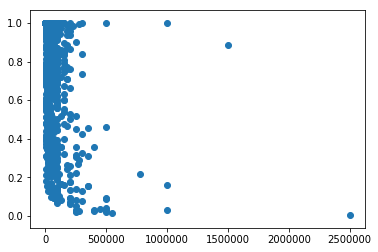

In [5]:
plt.scatter(dataframe['goal_clean'], dataframe['percent_of_goal'])

In [9]:
mask = (dataframe['goal_clean'] <= 500000)
dataframe_w_mask = dataframe[mask]


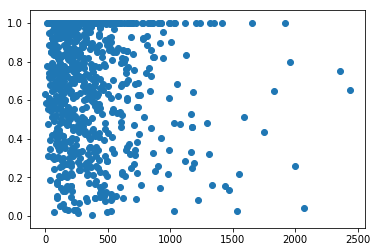

In [6]:
plt.scatter(dataframe['word_count'], dataframe['percent_of_goal'])

In [10]:
mask_word = (dataframe_w_mask.loc[:, 'word_count'] <=1500)
dataframe_w_mask_word = dataframe_w_mask[mask_word]

# Data Analysis
<a id='analysis'></a>

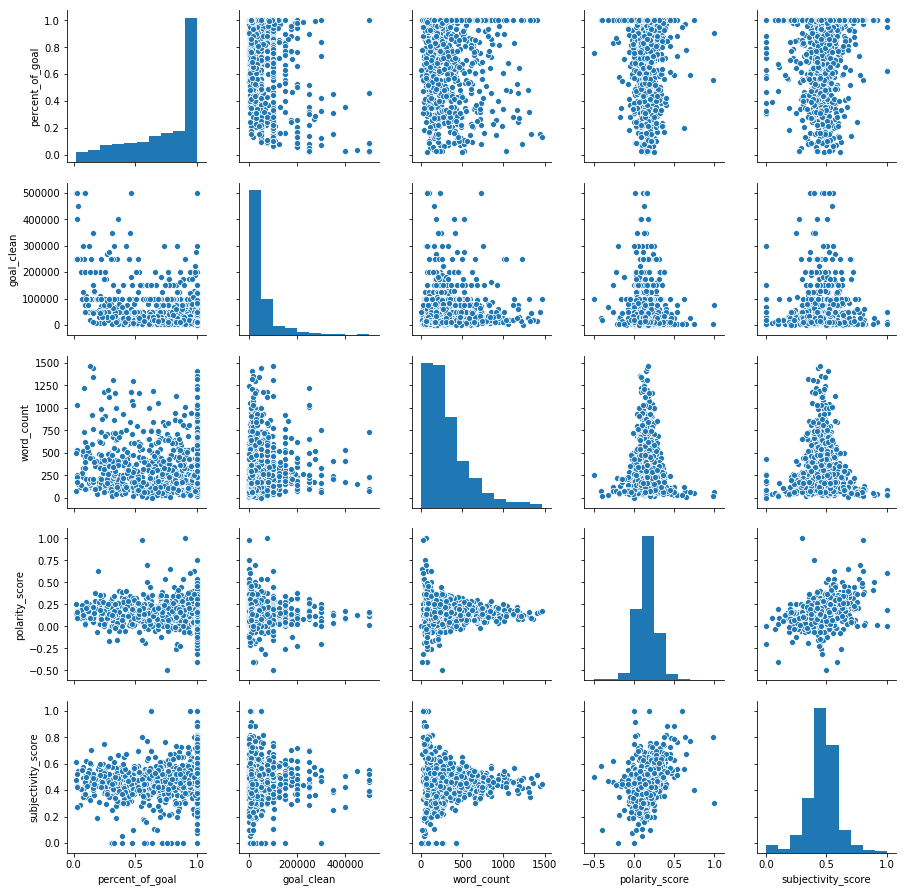

In [13]:
sns.pairplot(dataframe_w_mask_word.loc[:,['percent_of_goal','goal_clean', 'word_count', 'polarity_score', 'subjectivity_score']])

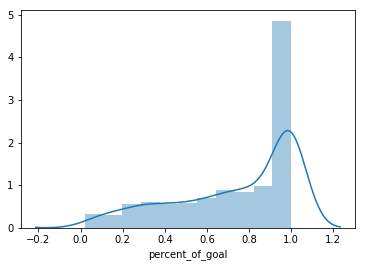

In [16]:
sns.distplot(dataframe_w_mask_word['percent_of_goal']) #check distribution of target.

In [17]:
#single linear regression with feature as goal_clean

import statsmodels.api as sm
X= (dataframe_w_mask_word['goal_clean'])
y= dataframe_w_mask_word['percent_of_goal']

results = sm.OLS(y,sm.add_constant(X)).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        percent_of_goal   R-squared:                       0.149
Model:                            OLS   Adj. R-squared:                  0.148
Method:                 Least Squares   F-statistic:                     164.9
Date:                Fri, 19 Jul 2019   Prob (F-statistic):           6.78e-35
Time:                        20:52:51   Log-Likelihood:                -86.130
No. Observations:                 941   AIC:                             176.3
Df Residuals:                     939   BIC:                             186.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8190      0.011     76.724      0.000       0.798       0.840
goal_clean -1.498e-06   1.17e-07    -12.843      0.000   -1.73e-06   -1.27e-06
==============================================================================
Omnibus:                       74.515   Durbin-Watson:                   1.466
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               73.738
Skew:                          -0.632   Prob(JB):                     9.73e-17
Kurtosis:                       2.467   Cond. No.                     1.13e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [18]:
#single linear regression with feature as word_count

import statsmodels.api as sm
X= (dataframe_w_mask['word_count'])
y= dataframe_w_mask['percent_of_goal']

results = sm.OLS(y,sm.add_constant(X)).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        percent_of_goal   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     23.69
Date:                Fri, 19 Jul 2019   Prob (F-statistic):           1.33e-06
Time:                        20:53:09   Log-Likelihood:                -156.13
No. Observations:                 952   AIC:                             316.3
Df Residuals:                     950   BIC:                             326.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7854      0.014     57.624      0.000       0.759       0.812
word_count    -0.0001   2.97e-05     -4.867      0.000      -0.000   -8.63e-05
==============================================================================
Omnibus:                      103.887   Durbin-Watson:                   1.804
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              110.847
Skew:                          -0.786   Prob(JB):                     8.51e-25
Kurtosis:                       2.431   Cond. No.                         676.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [19]:
#single linear regression stats with feature as polarity_score

import statsmodels.api as sm
X= (dataframe_w_mask['polarity_score'])
y= dataframe_w_mask['percent_of_goal']

results = sm.OLS(y,sm.add_constant(X)).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        percent_of_goal   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                   0.03501
Date:                Fri, 19 Jul 2019   Prob (F-statistic):              0.852
Time:                        20:53:44   Log-Likelihood:                -167.83
No. Observations:                 952   AIC:                             339.7
Df Residuals:                     950   BIC:                             349.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.7387      0.015     50.485      0.000       0.710       0.767
polarity_score    -0.0131      0.070     -0.187      0.852      -0.151       0.125
==============================================================================
Omnibus:                      111.835   Durbin-Watson:                   1.796
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              119.935
Skew:                          -0.818   Prob(JB):                     9.05e-27
Kurtosis:                       2.412   Cond. No.                         7.70
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [20]:
#single linear regression stats with feature as subjectivity_score
import statsmodels.api as sm
X= (dataframe_w_mask['subjectivity_score'])
y= dataframe_w_mask['percent_of_goal']

results = sm.OLS(y,sm.add_constant(X)).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        percent_of_goal   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     8.651
Date:                Fri, 19 Jul 2019   Prob (F-statistic):            0.00335
Time:                        20:54:27   Log-Likelihood:                -163.53
No. Observations:                 952   AIC:                             331.1
Df Residuals:                     950   BIC:                             340.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.6387      0.035     18.464      0.000       0.571       0.707
subjectivity_score     0.2107      0.072      2.941      0.003       0.070       0.351
==============================================================================
Omnibus:                      105.918   Durbin-Watson:                   1.807
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              119.185
Skew:                          -0.825   Prob(JB):                     1.32e-26
Kurtosis:                       2.467   Cond. No.                         9.37
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Modeling Baseline
<a id='baseline'></a>

In [21]:
X = dataframe_w_mask_word.loc[:, ['goal_clean', 'word_count', 'polarity_score', 'subjectivity_score']]
y= dataframe_w_mask_word.loc[:,'percent_of_goal']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=43)

In [22]:
lr_model = LinearRegression()

lr_model.fit(X_train, y_train)
lr_model.score(X_val, y_val)

0.1412705801267955

In [23]:
lr_model.score(X_test, y_test)

0.20199222004858475

# Feature Engineering & More Modeling
<a id='feature'></a>

In [24]:
#use polynomial features 

X = dataframe_w_mask_word.loc[:, ['goal_clean', 'word_count', 'polarity_score', 'subjectivity_score']]
y= dataframe_w_mask_word.loc[:,'percent_of_goal']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=43)

poly = PolynomialFeatures()
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)
X_train_val_poly = poly.fit_transform(X_train_val)

In [26]:
lr_model.fit(X_train_poly, y_train)
lr_model.score(X_train_val_poly, y_train_val)

0.18502772788221122

In [27]:
lr_model.score(X_test_poly, y_test)

0.19093354218729341

In [28]:
#Overfitting from polynomial features, maybe try to use ridge or lasso regularization.

def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

alphalist = 10**(np.linspace(-3,2,200))
err_vec_val = np.zeros(len(alphalist))
err_vec_train = np.zeros(len(alphalist))

for i,curr_alpha in enumerate(alphalist):

    # note the use of a new sklearn utility: Pipeline to pack
    # multiple modeling steps into one fitting process 
    steps = [('standardize', StandardScaler()), 
             ('ridge', Ridge(alpha = curr_alpha))]

    pipe = Pipeline(steps)
    pipe.fit(X_train, y_train)
    
    val_set_pred = pipe.predict(X_val)
    err_vec_val[i] = mae(y_val, val_set_pred)

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarn

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversi

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarn

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning

In [29]:
alphalist[np.argmin(err_vec_val)] #finding the alpha for ridge to minimize error

0.001

In [30]:
for i,curr_alpha in enumerate(alphalist):

    # note the use of a new sklearn utility: Pipeline to pack
    # multiple modeling steps into one fitting process 
    steps = [('standardize', StandardScaler()), 
             ('lasso', Lasso(alpha = curr_alpha))]

    pipe = Pipeline(steps)
    pipe.fit(X_train, y_train)
    
    val_set_pred = pipe.predict(X_val)
    err_vec_val[i] = mae(y_val, val_set_pred)

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarn

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarn

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversi

In [31]:
alphalist[np.argmin(err_vec_val)] #finding the alpha for lasso to minimize error

0.009547716114208056

In [32]:
# using 5 Fold validation to see whether simple linear regression, ridge, or lasso works best 
#to predict target using the polynomial features engineered.
X_, y_ = np.array(X_train_poly), np.array(y_train)

kf = KFold(n_splits=5, shuffle=True, random_state = 71)
cv_lm_r2s, cv_lm_ridge_r2s , lasso_scores= [], [], [] #collect the validation results for both models

for train_ind, val_ind in kf.split(X_,y_):
    
    X_train1, y_train1 = X_[train_ind], y_[train_ind]
    X_val1, y_val1 = X_[val_ind], y_[val_ind] 
    
    #simple linear regression
    lm = LinearRegression()
    lm_ridge = Ridge(alpha=.001)
    lasso_model = Lasso(alpha = .009547716114208056)

    lm.fit(X_train1, y_train1)
    cv_lm_r2s.append(lm.score(X_val1, y_val1))
    
    #ridge, lasso with feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train1)
    X_val_scaled = scaler.transform(X_val1)
    #linear with poly features
    
    
    lasso_model.fit(X_train_scaled, y_train1)
    lm_ridge.fit(X_train_scaled, y_train1)
    cv_lm_ridge_r2s.append(lm_ridge.score(X_val_scaled, y_val1))
    lasso_scores.append(lasso_model.score(X_val_scaled, y_val1))
    
print('Simple regression scores: ', cv_lm_r2s)
print('Ridge scores: ', cv_lm_ridge_r2s )
print('Lasso scores: ', lasso_scores ,'\n')

print(f'Simple mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}')
print(f'Ridge mean cv r^2: {np.mean(cv_lm_ridge_r2s):.3f} +- {np.std(cv_lm_ridge_r2s):.3f}')
print(f'Lasso mean cv r^2: {np.mean(lasso_scores): .3f} +- {np.std(lasso_scores): .3f}')

Simple regression scores:  [0.07275106149933319, 0.11427925270365503, 0.20087473212203877, 0.13092045065619629, 0.2095673219028269]
Ridge scores:  [0.07276633931137633, 0.11428392488192164, 0.20087229276898877, 0.13092328494414285, 0.209565293489237]
Lasso scores:  [0.13655658002151028, 0.11771122676222434, 0.15802640921560074, 0.15193707057898587, 0.21659311861304276] 

Simple mean cv r^2: 0.146 +- 0.052
Ridge mean cv r^2: 0.146 +- 0.052
Lasso mean cv r^2:  0.156 +-  0.033


In [33]:
lasso_model = Lasso(alpha = .001)
lasso_model.fit(X_train_val_poly, y_train_val)
lasso_model.score(X_test_poly, y_test)

0.20828097527444378

## Add more features- One Hot Encoding Categories

<a id = 'more features'></a>

In [34]:
dummy = pd.get_dummies(dataframe_w_mask_word['category'])

In [35]:
dataframe_mask_word_dummy = pd.concat([dataframe_w_mask_word, dummy], axis = 1)

In [36]:
#create dataframe with just categories and run regression models to see just impact of categories
X_new2 = dataframe_mask_word_dummy.loc[:,['animals', 'business', 'community',
                                       'competition', 'creative', 'education', 'emergency', 'event', 'faith',
                                       'family', 'medical', 'memorial', 'newlywed', 'nonprofit', 'other',
                                       'sports', 'travel', 'volunteer', 'wishes'
                                        ]]
y1_new2 = dataframe_mask_word_dummy.loc[:,'percent_of_goal']

In [37]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_new2, y1_new2, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=43)


In [39]:
lr_model.fit(X_train, y_train)
lr_model.score(X_val, y_val)

0.07915164055260071

In [40]:
lr_model.score(X_test, y_test)

-0.02816141691204832

In [41]:
for i,curr_alpha in enumerate(alphalist):

    # note the use of a new sklearn utility: Pipeline to pack
    # multiple modeling steps into one fitting process 
    steps = [('standardize', StandardScaler()), 
             ('ridge', Ridge(alpha = curr_alpha))]

    pipe = Pipeline(steps)
    pipe.fit(X_train, y_train)
    
    val_set_pred = pipe.predict(X_val)
    err_vec_val[i] = mae(y_val, val_set_pred)

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype uint8 were a

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype uint8 were a

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype uint8 were a

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8 wer

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8 wer

In [42]:
alphalist[np.argmin(err_vec_val)] # find best alpha for ridge regularization which minimizes error

0.001

In [43]:
alphalist = 10**(np.linspace(-3,2,200))
err_vec_val = np.zeros(len(alphalist))
err_vec_train = np.zeros(len(alphalist))

for i,curr_alpha in enumerate(alphalist):

    # note the use of a new sklearn utility: Pipeline to pack
    # multiple modeling steps into one fitting process 
    steps = [('standardize', StandardScaler()), 
             ('lasso', Lasso(alpha = curr_alpha))]

    pipe = Pipeline(steps)
    pipe.fit(X_train, y_train)
    
    val_set_pred = pipe.predict(X_val)
    err_vec_val[i] = mae(y_val, val_set_pred)

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype uint8 were a

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uin

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype uint8 were a

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8 wer

In [44]:
alphalist[np.argmin(err_vec_val)] # find best lasso alpha to minimize error

0.001

In [45]:
#cross validate to see whether a simple linear regression, ridge or lasso regularization works 
#best to predict target using just categories.

X_, y_ = np.array(X_train), np.array(y_train)

kf = KFold(n_splits=5, shuffle=True, random_state = 71)
cv_lm_r2s, cv_lm_ridge_r2s , lasso_scores= [], [], [] #collect the validation results for both models

for train_ind, val_ind in kf.split(X_,y_):
    
    X_train1, y_train1 = X_[train_ind], y_[train_ind]
    X_val1, y_val1 = X_[val_ind], y_[val_ind] 
    
    #simple linear regression
    lm = LinearRegression()
    lm_ridge = Ridge(alpha=.001)
    lasso_model = Lasso(alpha = .001)

    lm.fit(X_train1, y_train1)
    cv_lm_r2s.append(lm.score(X_val1, y_val1))
    
    #ridge, lasso with feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train1)
    X_val_scaled = scaler.transform(X_val1)
    #linear with poly features
    
    
    lasso_model.fit(X_train_scaled, y_train1)
    lm_ridge.fit(X_train_scaled, y_train1)
    cv_lm_ridge_r2s.append(lm_ridge.score(X_val_scaled, y_val1))
    lasso_scores.append(lasso_model.score(X_val_scaled, y_val1))
    
print('Simple regression scores: ', cv_lm_r2s)
print('Ridge scores: ', cv_lm_ridge_r2s )
print('Lasso scores: ', lasso_scores ,'\n')

print(f'Simple mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}')
print(f'Ridge mean cv r^2: {np.mean(cv_lm_ridge_r2s):.3f} +- {np.std(cv_lm_ridge_r2s):.3f}')
print(f'Lasso mean cv r^2: {np.mean(lasso_scores): .3f} +- {np.std(lasso_scores): .3f}')

Simple regression scores:  [0.19862619434026552, 0.06533305235018971, -0.03826261976943335, -0.026331960743098293, 0.12944713288592902]
Ridge scores:  [0.19862610090093047, 0.09269212642028046, -0.03826223990494193, -0.02633151144910184, 0.1294470276869214]
Lasso scores:  [0.19811688012591377, 0.09533950660634483, -0.030135949347896766, -0.021995370671969106, 0.1265060864080636] 

Simple mean cv r^2: 0.066 +- 0.091
Ridge mean cv r^2: 0.071 +- 0.091
Lasso mean cv r^2:  0.074 +-  0.088


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarni

In [46]:
lasso_model = Lasso(alpha = .001)
lasso_model.fit(X_train, y_train)
lasso_model.score(X_test, y_test)

-0.006220662523780618

In [47]:
#create the polynomial features/interactions of the goal_clean, word_count, polarity_score, and subjectivity_score features

dataframe_mask_word_dummy['goal_clean_sq']= dataframe_mask_word_dummy['goal_clean']**2
dataframe_mask_word_dummy['goal_clean*word_count']= dataframe_mask_word_dummy['goal_clean']*dataframe_mask_word_dummy['word_count']
dataframe_mask_word_dummy['goal_clean*polarity_score'] = dataframe_mask_word_dummy['goal_clean']*dataframe_mask_word_dummy['polarity_score']
dataframe_mask_word_dummy['goal_clean*subjectivity_score'] = dataframe_mask_word_dummy['goal_clean']*dataframe_mask_word_dummy['subjectivity_score']
dataframe_mask_word_dummy['word_count_sq']= dataframe_mask_word_dummy['word_count']**2
dataframe_mask_word_dummy['word_count*polarity_score']=dataframe_mask_word_dummy['word_count']*dataframe_mask_word_dummy['polarity_score']
dataframe_mask_word_dummy['word_count*subjectivity_score']=dataframe_mask_word_dummy['word_count']*dataframe_mask_word_dummy['subjectivity_score']
dataframe_mask_word_dummy['polarity_score_sq']=dataframe_mask_word_dummy['polarity_score']**2
dataframe_mask_word_dummy['polarity_score*subjectivity_score']=dataframe_mask_word_dummy['polarity_score']*dataframe_mask_word_dummy['subjectivity_score']
dataframe_mask_word_dummy['subjectivity_score_sq']=dataframe_mask_word_dummy['subjectivity_score']**2

In [48]:
#create features with the interactions of the first four features and dummified categories.
X2 = dataframe_mask_word_dummy.loc[:, ['goal_clean', 'word_count', 'polarity_score', 'subjectivity_score', 'goal_clean_sq', 
                                       'word_count_sq', 'goal_clean*word_count', 'goal_clean*polarity_score', 
                                       'goal_clean*subjectivity_score', 'word_count*polarity_score', 'word_count*subjectivity_score', 
                                       'polarity_score_sq', 'polarity_score*subjectivity_score', 'subjectivity_score_sq', 
                                       'animals', 'business', 'community',
                                       'competition', 'creative', 'education', 'emergency', 'event', 'faith',
                                       'family', 'medical', 'memorial', 'newlywed', 'nonprofit', 'other',
                                       'sports', 'travel', 'volunteer', 'wishes' ]]
y2 = dataframe_mask_word_dummy.loc[:,'percent_of_goal']

In [49]:
#fun to see statsmodel results for this new feature set.

results = sm.OLS(y2,sm.add_constant(X2)).fit()
results.summary()

/Applications/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        percent_of_goal   R-squared:                       0.464
Model:                            OLS   Adj. R-squared:                  0.445
Method:                 Least Squares   F-statistic:                     24.53
Date:                Fri, 19 Jul 2019   Prob (F-statistic):          1.07e-100
Time:                        21:17:59   Log-Likelihood:                 130.85
No. Observations:                 941   AIC:                            -195.7
Df Residuals:                     908   BIC:                            -35.75
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                 0.8901      0.049     18.016      0.000       0.793       0.987
goal_clean                        -4.779e-06   4.81e-07     -9.941      0.000   -5.72e-06   -3.84e-06
word_count                         1.809e-05      0.000      0.095      0.924      -0.000       0.000
polarity_score                        0.0577      0.230      0.251      0.802      -0.394       0.509
subjectivity_score                   -0.0815      0.211     -0.386      0.699      -0.495       0.332
goal_clean_sq                      7.474e-12      7e-13     10.676      0.000     6.1e-12    8.85e-12
word_count_sq                     -3.899e-08   7.44e-08     -0.524      0.600   -1.85e-07    1.07e-07
goal_clean*word_count             -1.758e-10   4.25e-10     -0.413      0.679   -1.01e-09    6.59e-10
goal_clean*polarity_score         -2.466e-06    1.1e-06     -2.240      0.025   -4.63e-06   -3.05e-07
goal_clean*subjectivity_score      3.331e-07   8.88e-07      0.375      0.708   -1.41e-06    2.08e-06
word_count*polarity_score            -0.0002      0.000     -0.584      0.559      -0.001       0.001
word_count*subjectivity_score     -3.313e-05      0.000     -0.088      0.930      -0.001       0.001
polarity_score_sq                     0.0442      0.164      0.269      0.788      -0.278       0.366
polarity_score*subjectivity_score     0.0279      0.378      0.074      0.941      -0.715       0.770
subjectivity_score_sq                 0.1943      0.238      0.816      0.415      -0.273       0.662
animals                               0.0084      0.029      0.294      0.769      -0.048       0.065
business                             -0.1917      0.030     -6.464      0.000      -0.250      -0.133
community                             0.0254      0.027      0.956      0.339      -0.027       0.078
competition                          -0.1857      0.036     -5.161      0.000      -0.256      -0.115
creative                             -0.0048      0.029     -0.164      0.869      -0.062       0.053
education                             0.0898      0.029      3.097      0.002       0.033       0.147
emergency                             0.3536      0.030     11.826      0.000       0.295       0.412
event                                 0.0043      0.030      0.145      0.885      -0.054       0.063
faith                                -0.0786      0.029     -2.697      0.007      -0.136      -0.021
family                                0.1909      0.031      6.244      0.000       0.131       0.251
medical                               0.4366      0.033     13.056      0.000       0.371       0.502
memorial                              0.3461      0.031     11.100      0.000       0.285       0.407
newlywed               

In [50]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X2, y2, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=43)

In [51]:
for i,curr_alpha in enumerate(alphalist):

    # note the use of a new sklearn utility: Pipeline to pack
    # multiple modeling steps into one fitting process 
    steps = [('standardize', StandardScaler()), 
             ('ridge', Ridge(alpha = curr_alpha))]

    pipe = Pipeline(steps)
    pipe.fit(X_train, y_train)
    
    val_set_pred = pipe.predict(X_val)
    err_vec_val[i] = mae(y_val, val_set_pred)

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/base.p

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/dat

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/p

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/base.p

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/p

In [52]:
alphalist[np.argmin(err_vec_val)] #find best alpha for ridge regularization that minimizes error.

1.3049019780144029

In [53]:
for i,curr_alpha in enumerate(alphalist):

    # note the use of a new sklearn utility: Pipeline to pack
    # multiple modeling steps into one fitting process 
    steps = [('standardize', StandardScaler()), 
             ('lasso', Lasso(alpha = curr_alpha))]

    pipe = Pipeline(steps)
    pipe.fit(X_train, y_train)
    
    val_set_pred = pipe.predict(X_val)
    err_vec_val[i] = mae(y_val, val_set_pred)

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/base.p

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/dat

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/p

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/p

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/base.p

In [54]:
alphalist[np.argmin(err_vec_val)] # find best alpha for lasso regularization that minimizes error.

0.001

In [55]:
#cross validate using 5 fold validation to see whether simple linear regression, lasso or ridge
#regularization works best for our new feature set that includes polynomial features 
#and dummified categories.
X_, y_ = np.array(X_train), np.array(y_train)

kf = KFold(n_splits=5, shuffle=True, random_state = 71)
cv_lm_r2s, cv_lm_ridge_r2s , lasso_scores= [], [], [] #collect the validation results for both models

for train_ind, val_ind in kf.split(X_,y_):
    
    X_train1, y_train1 = X_[train_ind], y_[train_ind]
    X_val1, y_val1 = X_[val_ind], y_[val_ind] 
    
    #simple linear regression
    lm = LinearRegression()
    lm_ridge = Ridge(alpha=1.3049019780144029)
    lasso_model = Lasso(alpha = .001)

    lm.fit(X_train1, y_train1)
    cv_lm_r2s.append(lm.score(X_val1, y_val1))
    
    #ridge, lasso with feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train1)
    X_val_scaled = scaler.transform(X_val1)
    #linear with poly features
    
    
    lasso_model.fit(X_train_scaled, y_train1)
    lm_ridge.fit(X_train_scaled, y_train1)
    cv_lm_ridge_r2s.append(lm_ridge.score(X_val_scaled, y_val1))
    lasso_scores.append(lasso_model.score(X_val_scaled, y_val1))
    
print('Simple regression scores: ', cv_lm_r2s)
print('Ridge scores: ', cv_lm_ridge_r2s )
print('Lasso scores: ', lasso_scores ,'\n')

print(f'Simple mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}')
print(f'Ridge mean cv r^2: {np.mean(cv_lm_ridge_r2s):.3f} +- {np.std(cv_lm_ridge_r2s):.3f}')
print(f'Lasso mean cv r^2: {np.mean(lasso_scores): .3f} +- {np.std(lasso_scores): .3f}')

Simple regression scores:  [0.3574515650848509, 0.39187393007051596, 0.3796770254075955, 0.34630392817934286, 0.5067102950987303]
Ridge scores:  [0.3695460732306116, 0.39838596338521015, 0.3711886254455937, 0.3492615529619597, 0.5024877225398371]
Lasso scores:  [0.3807339899745644, 0.4066521482353215, 0.37657345481029625, 0.3593620064465233, 0.5101509640509447] 

Simple mean cv r^2: 0.396 +- 0.057
Ridge mean cv r^2: 0.398 +- 0.054
Lasso mean cv r^2:  0.407 +-  0.054


In [56]:
lasso_model = Lasso(alpha = .001)
lasso_model.fit(X_train, y_train)
lasso_model.score(X_test, y_test)

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.3906743587815704

# Intepreting Results
<a id='interpret'></a>

In [57]:
a = sorted(list(zip(X_train.columns, lasso_model.coef_ )), key=lambda x:(x[1]), reverse=True)
a

[('medical', 0.3939840914334812),
 ('emergency', 0.2849077417791859),
 ('memorial', 0.25284024789544857),
 ('family', 0.18940689778704448),
 ('education', 0.1382794415261553),
 ('other', 0.07461738325044404),
 ('subjectivity_score_sq', 0.07397029945150023),
 ('nonprofit', 0.052746833775902946),
 ('wishes', 0.0513852522710469),
 ('word_count*subjectivity_score', 0.00011875147518971095),
 ('goal_clean*subjectivity_score', 2.1508561771558835e-06),
 ('goal_clean_sq', 7.102602539819685e-12),
 ('polarity_score', 0.0),
 ('subjectivity_score', 0.0),
 ('polarity_score_sq', 0.0),
 ('polarity_score*subjectivity_score', 0.0),
 ('animals', -0.0),
 ('community', 0.0),
 ('creative', -0.0),
 ('goal_clean*word_count', -1.5720016075176958e-10),
 ('word_count_sq', -3.766954839421373e-08),
 ('goal_clean*polarity_score', -2.074882838465249e-06),
 ('goal_clean', -5.44648870617854e-06),
 ('word_count', -7.457291416761661e-05),
 ('word_count*polarity_score', -0.00014562126703453592),
 ('event', -0.01938133843

In [86]:
for element in enumerate(a):
    print(element)

(0, ('medical', 0.3939840914334812))
(1, ('emergency', 0.2849077417791859))
(2, ('memorial', 0.25284024789544857))
(3, ('family', 0.18940689778704448))
(4, ('education', 0.1382794415261553))
(5, ('other', 0.07461738325044404))
(6, ('nonprofit', 0.052746833775902946))
(7, ('wishes', 0.0513852522710469))
(8, ('animals', -0.0))
(9, ('community', 0.0))
(10, ('creative', -0.0))
(11, ('event', -0.019381338431001267))
(12, ('faith', -0.04508570510758912))
(13, ('travel', -0.04522014829876775))
(14, ('volunteer', -0.04911162555188249))
(15, ('sports', -0.07274281136379179))
(16, ('competition', -0.15894053578434594))
(17, ('business', -0.18035921867073346))
(18, ('newlywed', -0.18381321720188465))


In [85]:
a.pop(11)

('word_count*polarity_score', -0.00014562126703453592)

Text(0.5, 1.0, 'Percent Boost or Reduction of Goal by Category')

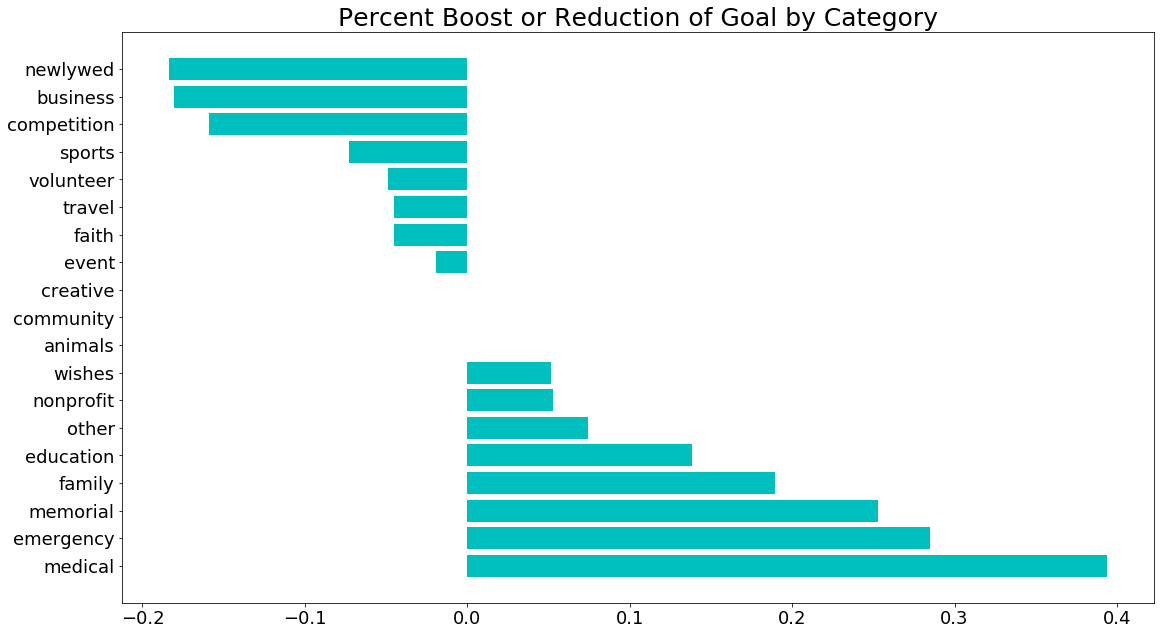

In [87]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.barh(range(len(a)), [val[1] for val in a], align='center', color = 'c')
plt.yticks(range(len(a)), [val[0] for val in a])
plt.yticks(size =18)
plt.xticks(size=18)
plt.title('Percent Boost or Reduction of Goal by Category', size=25)

In [7]:
dataframe_w_mask_word.loc[:, ['goal_clean', 'percent_of_goal', 'word_count', 'days_active', 'polarity_score', 'subjectivity_score']].describe()

,goal_clean,percent_of_goal,word_count,days_active,polarity_score,subjectivity_score
count,941.000000,941.000000,941.000000,941.000000,941.000000,941.000000
mean,53583.940489,0.738747,318.285866,108.533475,0.160025,0.465167
std,74213.957804,0.287662,259.834338,234.339861,0.133964,0.130704
min,1.000000,0.019842,1.000000,1.000000,-0.500000,0.000000
25%,10000.000000,0.533200,133.000000,62.000000,0.088235,0.407762
50%,25000.000000,0.837592,244.000000,105.000000,0.151662,0.473718
75%,75000.000000,1.000000,428.000000,143.000000,0.226376,0.529816
max,500000.000000,1.000000,1468.000000,7132.000000,1.000000,1.000000


# Extra- Residual Plot 
<a id='residual'></a>

In [8]:
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

In [14]:
X5 = dataframe_w_mask_word.loc[:, ['goal_clean', 'word_count', 'polarity_score', 'subjectivity_score']]
y5= dataframe_w_mask_word.loc[:,'percent_of_goal']

X_train_val, X_test, y_train_val, y_test = train_test_split(X5, y5, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=43)


In [18]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
train_set_pred = lr_model.predict(X_train)
test_set_pred = lr_model.predict(X_test)

Text(0.5, 1.0, 'Residual Plot of four features vs. percent of goal')

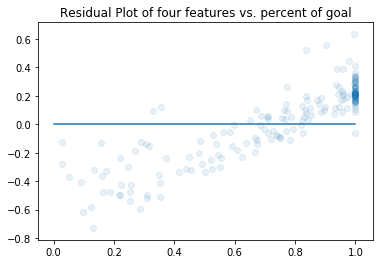

In [19]:
plt.scatter(y_test,y_test-test_set_pred,alpha=.1)
plt.plot(np.linspace(0,1,1000),np.linspace(0,0,1000))
plt.title('Residual Plot of four features vs. percent of goal')